# Importing Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets,layers,models
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [ ]:
# import random
# # fair evaluations of different configurations by maintaining randomness consistency during Hyperparameter tuning
# seed_constant=27
# np.random.seed(seed_constant)
# random.seed(seed_constant)
# tf.random.set_seed(seed_constant)

# Dataset loading and creation


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# list of classes classified by our model
CLASSES_LIST=["aadhar","passport","driver license","pan","voter"]


##creating train and validate data

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

IMG_SIZE = (224, 224)  # image  will be resized to 224 pixels in height and 224 pixels in width for model training
batch_size = 32        # Adjust based on  GPU memory

# Creating the training dataset
#subset='training' tells the function to use the part of the data designated for training(80% in this case)
train_dataset = image_dataset_from_directory(
    '/content/drive/MyDrive/id_card_dataset/train',
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=batch_size)

# Creating the validation dataset
#subset='validation' tells the function to use the remaining part of the data (20% in this case) for validation
validation_dataset = image_dataset_from_directory(
    '/content/drive/MyDrive/id_card_dataset/train',
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=batch_size)




Found 340 files belonging to 5 classes.
Using 272 files for training.
Found 340 files belonging to 5 classes.
Using 68 files for validation.


##class wise dataset distribution

Class 'voter': 67 images
Class 'passport': 37 images
Class 'pan': 45 images
Class 'driver license': 62 images
Class 'aadhar': 129 images


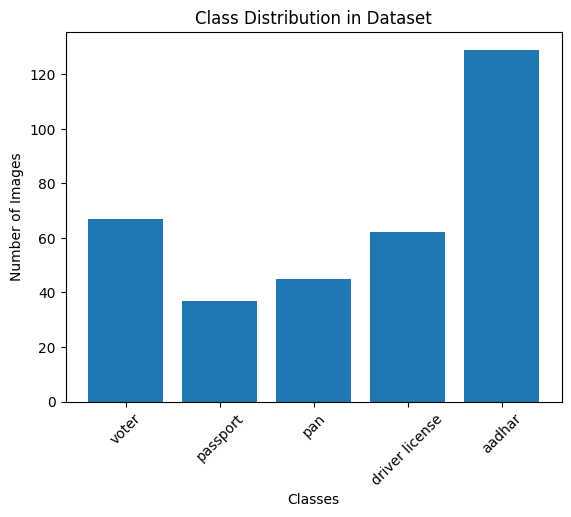

In [ ]:
import os

# Path to your dataset
dataset_path = '/content/drive/MyDrive/id_card_dataset/train'

# Initialize a dictionary to hold the count of images per class
class_distribution = {}

# Loop through each class in the dataset directory
for class_name in os.listdir(dataset_path):
    # Construct the path to the class's folder
    class_folder = os.path.join(dataset_path, class_name)

    # Check if it's a directory
    if os.path.isdir(class_folder):
        # Count the number of images in this folder
        num_images = len(os.listdir(class_folder))

        # Update the dictionary
        class_distribution[class_name] = num_images

# Print the class distribution
for class_name, count in class_distribution.items():
    print(f"Class '{class_name}': {count} images")

try:
    import matplotlib.pyplot as plt

    plt.bar(class_distribution.keys(), class_distribution.values())
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution in Dataset')
    plt.xticks(rotation=45)
    plt.show()
except ImportError:
    print("matplotlib is not installed")


## data normalisation and augmentation

In [ ]:
!ls "/content/drive/MyDrive/id_card_dataset/test"


 aadhar  'driver license'   pan   passport   voter


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming IMG_SIZE is defined (e.g., IMG_SIZE = (224, 224))
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.2,  # Range (as a fraction of total width) for horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for vertical shifts
    shear_range=0.2,  # Shear Intensity (Shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest'  # Strategy to fill newly created pixels
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/id_card_dataset/train',
    target_size=IMG_SIZE,  # Resize the images
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Set as training data
)

validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/id_card_dataset/train',
    target_size=IMG_SIZE,  # Resize the images
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the test data generator with only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a flow from the directory for the test set
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/id_card_dataset/test',  # Update with your test data path
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important: keep data in same order for evaluation
)



Found 274 images belonging to 5 classes.
Found 65 images belonging to 5 classes.
Found 23 images belonging to 5 classes.


doesn't physically increase the size of your dataset stored on disk. Instead, it dynamically augments the images in real-time during the model training process.

# VGG 16

In [ ]:
from tensorflow.keras.applications import VGG16, VGG19

# Load VGG16 model pre-trained on ImageNet
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Load VGG19 model pre-trained on ImageNet
# vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [ ]:
for layer in vgg16_model.layers:
    layer.trainable = False

# for layer in vgg19_model.layers:
#     layer.trainable = False


In [ ]:
from tensorflow.keras import layers, models

# Adding custom layers on top of VGG16
vgg16_custom = models.Sequential()
vgg16_custom.add(vgg16_model)
vgg16_custom.add(layers.Flatten())
vgg16_custom.add(layers.Dense(256, activation='relu'))
vgg16_custom.add(layers.Dropout(0.5))
vgg16_custom.add(layers.Dense(5, activation='softmax'))  # Assuming 5 classes


In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True)

In [ ]:
vgg16_custom.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = vgg16_custom.fit(train_generator, validation_data=validation_generator, epochs=15, callbacks=[early_stopping_callback])

Epoch 1/15
9/9 [==============================] - 20s 1s/step - loss: 3.6933 - accuracy: 0.3102 - val_loss: 1.0363 - val_accuracy: 0.7077
Epoch 2/15
9/9 [==============================] - 12s 1s/step - loss: 1.4379 - accuracy: 0.5949 - val_loss: 0.8500 - val_accuracy: 0.6769
Epoch 3/15
9/9 [==============================] - 7s 781ms/step - loss: 0.8967 - accuracy: 0.6569 - val_loss: 0.7630 - val_accuracy: 0.6769
Epoch 4/15
9/9 [==============================] - 8s 816ms/step - loss: 0.7934 - accuracy: 0.7190 - val_loss: 0.6605 - val_accuracy: 0.8154
Epoch 5/15
9/9 [==============================] - 8s 961ms/step - loss: 0.6115 - accuracy: 0.7628 - val_loss: 0.7611 - val_accuracy: 0.6615
Epoch 6/15
9/9 [==============================] - 8s 850ms/step - loss: 0.5154 - accuracy: 0.7883 - val_loss: 0.5885 - val_accuracy: 0.7692
Epoch 7/15
9/9 [==============================] - 8s 929ms/step - loss: 0.5014 - accuracy: 0.8102 - val_loss: 0.6227 - val_accuracy: 0.8154
Epoch 8/15
9/9 [========

In [ ]:
vgg16_custom.save('15epochs87.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
